<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Meta/blob/master/Demo_FinRL_Meta_Integrate_Trends_data_to_DOW_Jones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
%%capture
!pip3 install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use('Agg')
import datetime
import os
import optuna
import torch 

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
#from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent as DRLAgent_sb3

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



## Custom data processor

* Only add a functionality add_user_defined_features to data processor 

In [ ]:
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor as Alpaca
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor as Wrds
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor as YahooFinance
import pandas as pd
import numpy as np

class Custom_DataProcessor():
    def __init__(self, data_source, **kwargs):
        if data_source == 'alpaca':
            
            try:
                API_KEY= kwargs.get('API_KEY')
                API_SECRET= kwargs.get('API_SECRET')
                APCA_API_BASE_URL= kwargs.get('APCA_API_BASE_URL')
                self.processor = Alpaca(API_KEY, API_SECRET, APCA_API_BASE_URL)
                print('Alpaca successfully connected')
            except:
                raise ValueError('Please input correct account info for alpaca!')
                
        elif data_source == 'wrds':
            self.processor = Wrds()
            
        elif data_source == 'yahoofinance':
            self.processor = YahooFinance()
        
        else:
            raise ValueError('Data source input is NOT supported yet.')
    
    def download_data(self, ticker_list, start_date, end_date, 
                      time_interval) -> pd.DataFrame:
        df = self.processor.download_data(ticker_list = ticker_list, 
                                          start_date = start_date, 
                                          end_date = end_date,
                                          time_interval = time_interval)
        return df
    
    def clean_data(self, df) -> pd.DataFrame:
        df = self.processor.clean_data(df)
        
        return df
    
    def add_technical_indicator(self, df, tech_indicator_list) -> pd.DataFrame:
        # self.tech_indicator_list = tech_indicator_list
        df = self.processor.add_technical_indicator(df, tech_indicator_list)
        
        return df
    
    def add_turbulence(self, df) -> pd.DataFrame:
        df = self.processor.add_turbulence(df)
        
        return df
    
    def add_vix(self, df) -> pd.DataFrame:
        df = self.processor.add_vix(df)
        
        return df
    
    def add_user_defined_features(self,data,user_df) -> pd.DataFrame:
        df = data.copy()
        df = df.merge(user_df, how='left', left_on=[
            'time', 'tic'], right_on=['time', 'tic'])
        return df
    
    def df_to_array(self, df, tech_indicator_list, if_vix) -> np.array:
        price_array,tech_array,turbulence_array = self.processor.df_to_array(df,
                                                tech_indicator_list,
                                                if_vix)
        #fill nan with 0 for technical indicators
        tech_nan_positions = np.isnan(tech_array)
        tech_array[tech_nan_positions] = 0
        
        return price_array,tech_array,turbulence_array

## User defined column

In [ ]:
# !gdown --id "1sp11dtAJGGqC-3UdSn774ZD1zWCsqbn4"
!gdown --id "1m63ncE-BYlS77u5ejYTte9Nmh35DWhzp"

Downloading...
From: https://drive.google.com/uc?id=1m63ncE-BYlS77u5ejYTte9Nmh35DWhzp
To: /content/Pytrends.zip
100% 318k/318k [00:00<00:00, 47.1MB/s]


In [ ]:
!unzip "/content/Pytrends.zip"

Archive:  /content/Pytrends.zip
  inflating: Pytrends/Pytrends_Data/AAPL_5.csv  
  inflating: Pytrends/Pytrends_Data/AXP_7.csv  
  inflating: Pytrends/Pytrends_Data/BA_356.csv  
  inflating: Pytrends/Pytrends_Data/CAT_48.csv  
  inflating: Pytrends/Pytrends_Data/CSCO_5.csv  
  inflating: Pytrends/Pytrends_Data/CVX_233.csv  
  inflating: Pytrends/Pytrends_Data/DD_288.csv  
  inflating: Pytrends/Pytrends_Data/DIS_3.csv  
  inflating: Pytrends/Pytrends_Data/GS_7.csv  
  inflating: Pytrends/Pytrends_Data/HD_11.csv  
  inflating: Pytrends/Pytrends_Data/IBM_5.csv  
  inflating: Pytrends/Pytrends_Data/INTC_5.csv  
  inflating: Pytrends/Pytrends_Data/JNJ_45.csv  
  inflating: Pytrends/Pytrends_Data/JPM_7.csv  
  inflating: Pytrends/Pytrends_Data/KO_71.csv  
  inflating: Pytrends/Pytrends_Data/MCD_276.csv  
  inflating: Pytrends/Pytrends_Data/MMM_12.csv  
  inflating: Pytrends/Pytrends_Data/MRK_45.csv  
  inflating: Pytrends/Pytrends_Data/MSFT_13.csv  
  inflating: Pytrends/Pytrends_Data/NKE_18

In [ ]:
ticker_list = config.DOW_30_TICKER
#Pytrends dataframe
def get_user_df():
    pytrends_list = os.listdir('Pytrends_Data')
    
    user_df = pd.DataFrame()
    for pytrend in pytrends_list:
        tic_name = pytrend.split('_')[0]
        if tic_name in ticker_list:
            file_name = os.path.join('Pytrends_Data', pytrend)
            temp_user_df = pd.read_csv(file_name)
            temp_user_df.rename(columns={temp_user_df.columns[1]:'trends'},inplace=True)
            temp_user_df.rename(columns={temp_user_df.columns[0]:'time'},inplace=True)
            temp_user_df['tic'] = tic_name
            user_df = user_df.append(temp_user_df, ignore_index=True)
    return user_df

In [ ]:
user_df = get_user_df()
len(user_df)

87475

## Training and testing

In [ ]:
technical_indicator_list = []

info_col = technical_indicator_list + ['trends']

In [ ]:
def ppo_sample_parameters(trial:optuna.Trial):
  batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
  n_steps = trial.suggest_categorical("n_steps", [128, 256, 512, 1024, 2048])
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)
  ent_coef = trial.suggest_loguniform("ent_coef", 0.00000001, 0.1)

  return {
      "batch_size": batch_size,
      'n_steps': n_steps,
      'learning_rate': learning_rate,
      'ent_coef': ent_coef 
  }

In [ ]:
os.makedirs('tuned_models',exist_ok=True)

In [ ]:
from IPython.display import clear_output
def get_train_env(start_date, end_date, ticker_list, data_source, time_interval,model_name,env,
          info_col, if_vix=True,
          **kwargs):

    DP = Custom_DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_user_defined_features(data,user_df) #Adding Google trends data to our state space
    data = DP.add_technical_indicator(data, technical_indicator_list)
    if if_vix:
        data = DP.add_vix(data)
    # Passed info col instead of tech_indicator_list.
    price_array, tech_array, turbulence_array = DP.df_to_array(
        data,info_col, if_vix)
    env_config = {'price_array':price_array,
              'tech_array':tech_array,
              'turbulence_array':turbulence_array,
              'if_train':True}
    env_instance = env(config=env_config)
    

    return env_instance

def objective(trial:optuna.Trial):
    agent_params = ppo_sample_parameters(trial)
    tune_cwd = 'tuned_models/'+str(model_name)+'_' + str(agent_params.values())
    agent = DRLAgent_sb3(env = train_env_instance)

    model = agent.get_model(model_name, model_kwargs = agent_params)
    trained_model = agent.train_model(model=model, 
                            tb_log_name=model_name,
                            total_timesteps=total_timesteps)
    clear_output(wait=True)
    trained_model.save(tune_cwd)

    val_sharpe,_ = val_or_test(val_env_instance,tune_cwd,model_name)

    return val_sharpe

In [ ]:
def calculate_sharpe(df):
  df['daily_return'] = df['account_value'].pct_change(1)
  if df['daily_return'].std() !=0:
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
          df['daily_return'].std()
    return sharpe
  else:
    return 0

In [ ]:
def get_test_env(start_date, end_date, ticker_list, data_source, time_interval, 
         info_col, env, model_name, if_vix = True,
         **kwargs):
    #fetch data
    DP = Custom_DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_user_defined_features(data,user_df)
    data = DP.add_technical_indicator(data, technical_indicator_list)
    
    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data,info_col, if_vix)
    
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':False}
    test_env_instance = env(config=env_config)
    return test_env_instance

def val_or_test(test_env_instance,cwd,model_name): 
    episode_total_assets = DRLAgent_sb3.DRL_prediction_load_from_file(
                                  model_name=model_name, 
                                  environment = test_env_instance,
                                  cwd = cwd)
    sharpe_df = pd.DataFrame(episode_total_assets,columns=['account_value'])

    return calculate_sharpe(sharpe_df),sharpe_df

In [ ]:
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import StockTradingEnv

In [ ]:
TRAIN_START_DATE = '2012-01-01'
TRAIN_END_DATE = '2019-07-30'

VAL_START_DATE = '2019-08-01'
VAL_END_DATE = '2020-07-30'
TEST_START_DATE = '2020-08-01'
TEST_END_DATE = '2021-10-01'

PPO_PARAMS = {"n_steps": 2048,"ent_coef": 0.01,"learning_rate": 0.00025,"batch_size": 128}
SAC_PARAMS = {"batch_size": 128,"buffer_size": 100000,"learning_rate": 0.0001,"learning_starts": 100,"ent_coef": "auto_0.1",}
TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 3e-5}


data_source = 'yahoofinance'
time_interval = '1D'
model_name = 'ppo'
total_timesteps = 30000

env = StockTradingEnv

In [ ]:
train_env_instance = get_train_env(TRAIN_START_DATE, TRAIN_END_DATE, 
                                   ticker_list, data_source, 
                                   time_interval,model_name,
                                   env,info_col)
val_env_instance = get_test_env(VAL_START_DATE, VAL_END_DATE, 
                                ticker_list, data_source,
                                time_interval, info_col, env, model_name)                         

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(study_name="ppo_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=30,catch=(ValueError,))

Successfully load model tuned_models/ppo_dict_values([128, 512, 0.0007673258936182707, 4.0887966034571854e-07])


[I 2021-12-04 05:52:19,819] Trial 29 finished with value: 0.3443457527774958 and parameters: {'batch_size': 128, 'n_steps': 512, 'learning_rate': 0.0007673258936182707, 'ent_coef': 4.0887966034571854e-07}. Best is trial 18 with value: 0.9698070844319996.


episode_return 1.061074535325915
Test Finished!


In [ ]:
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'batch_size': 64, 'n_steps': 128, 'learning_rate': 0.00070871461180512, 'ent_coef': 8.288429700474578e-06}
0.9698070844319996
FrozenTrial(number=18, values=[0.9698070844319996], datetime_start=datetime.datetime(2021, 12, 4, 5, 29, 41, 766117), datetime_complete=datetime.datetime(2021, 12, 4, 5, 31, 40, 531568), params={'batch_size': 64, 'n_steps': 128, 'learning_rate': 0.00070871461180512, 'ent_coef': 8.288429700474578e-06}, distributions={'batch_size': CategoricalDistribution(choices=(64, 128, 256, 512)), 'n_steps': CategoricalDistribution(choices=(128, 256, 512, 1024, 2048)), 'learning_rate': LogUniformDistribution(high=1.0, low=1e-05), 'ent_coef': LogUniformDistribution(high=0.1, low=1e-08)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)


In [ ]:
test_env_instance = get_test_env(TEST_START_DATE, TEST_END_DATE, 
                                ticker_list, data_source,
                                time_interval, info_col, env, model_name)    
test_cwd = 'tuned_models/'+str(model_name)+'_' + str(study.best_params.values())
test_sharpe,df_account_value = val_or_test(test_env_instance,test_cwd,model_name)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Backtesting

In [ ]:
baseline_df =  Custom_DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (294, 9)
Annual return          0.226750
Cumulative returns     0.269255
Annual volatility      0.139601
Sharpe ratio           1.539212
Calmar ratio           2.538976
Stability              0.915926
Max drawdown          -0.089308
Omega ratio            1.294292
Sortino ratio          2.240389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995019
Daily value at risk   -0.016735
dtype: float64


In [ ]:
os.chdir('/content/tuned_models')
for test_cwd in os.listdir():
  test_sharpe,df_account_value = val_or_test(test_env_instance,test_cwd,model_name)
  print(test_cwd,test_sharpe)

Successfully load model ppo_dict_values([64, 128, 0.010531029274477015, 3.9727013350751415e-06])
episode_return 1.194567131261364
Test Finished!
ppo_dict_values([64, 128, 0.010531029274477015, 3.9727013350751415e-06]) 1.2043951699192958
Successfully load model ppo_dict_values([128, 256, 1.485739280627924e-05, 0.023186906702901938])
episode_return 1.2784151475829195
Test Finished!
ppo_dict_values([128, 256, 1.485739280627924e-05, 0.023186906702901938]) 1.2932091006337125
Successfully load model ppo_dict_values([512, 128, 0.07309566663479626, 6.923045530902925e-05])
episode_return 1.2123776842740706
Test Finished!
ppo_dict_values([512, 128, 0.07309566663479626, 6.923045530902925e-05]) 1.2388528466132294
Successfully load model ppo_dict_values([64, 512, 0.0016074402715139128, 0.0001575744902755833])
episode_return 1.5206603249403399
Test Finished!
ppo_dict_values([64, 512, 0.0016074402715139128, 0.0001575744902755833]) 2.151584172296769
Successfully load model ppo_dict_values([128, 1024, 

In [ ]:
# !mkdir 'drive/MyDrive/tuned_models_DOW_JONES'
# !mv 'tuned_models_DOW_JONES' 'drive/MyDrive/tuned_models'

In [ ]:
#Best test sharpe
best_test_cwd = "ppo_dict_values([64, 128, 0.0007114879943759374, 1.7734195965746112e-05])"
# ppo_dict_values([256, 256, 0.00013931273790066692, 3.4582737549732e-08])

test_sharpe,df_account_value = val_or_test(test_env_instance,best_test_cwd,model_name)

Successfully load model ppo_dict_values([64, 128, 0.0007114879943759374, 1.7734195965746112e-05])
episode_return 1.5249040093782738
Test Finished!


In [ ]:
account_value_sb3 = list(df_account_value['account_value'])
account_value_sb3 = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_sb3[0:len(account_value_sb3)-1]})
perf_stats_all = backtest_stats(account_value=account_value_sb3)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.435719
Cumulative returns     0.524922
Annual volatility      0.201401
Sharpe ratio           1.903244
Calmar ratio           4.444814
Stability              0.932461
Max drawdown          -0.098029
Omega ratio            1.374319
Sortino ratio          2.996636
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.119414
Daily value at risk   -0.023853
dtype: float64


In [ ]:
account_value_sb3.tail()

,date,account_value
289,2021-09-24,1.574923e+06
290,2021-09-27,1.591800e+06
291,2021-09-28,1.554911e+06
292,2021-09-29,1.550041e+06
293,2021-09-30,1.524922e+06


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (293, 8)


Start date,2020-08-03
End date,2021-09-30
Total months,14
,Backtest
Annual return,43.572%
Cumulative returns,52.492%
Annual volatility,20.14%
Sharpe ratio,1.90
Calmar ratio,4.44
Stability,0.93
Max drawdown,-9.803%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.80,2020-09-02,2020-10-28,2020-11-09,49
1,8.24,2021-09-02,2021-09-21,NaT,NaN
2,7.01,2021-06-04,2021-06-18,2021-07-12,27
3,6.71,2021-01-14,2021-01-29,2021-02-08,18
4,5.02,2021-07-12,2021-07-19,2021-08-03,17


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



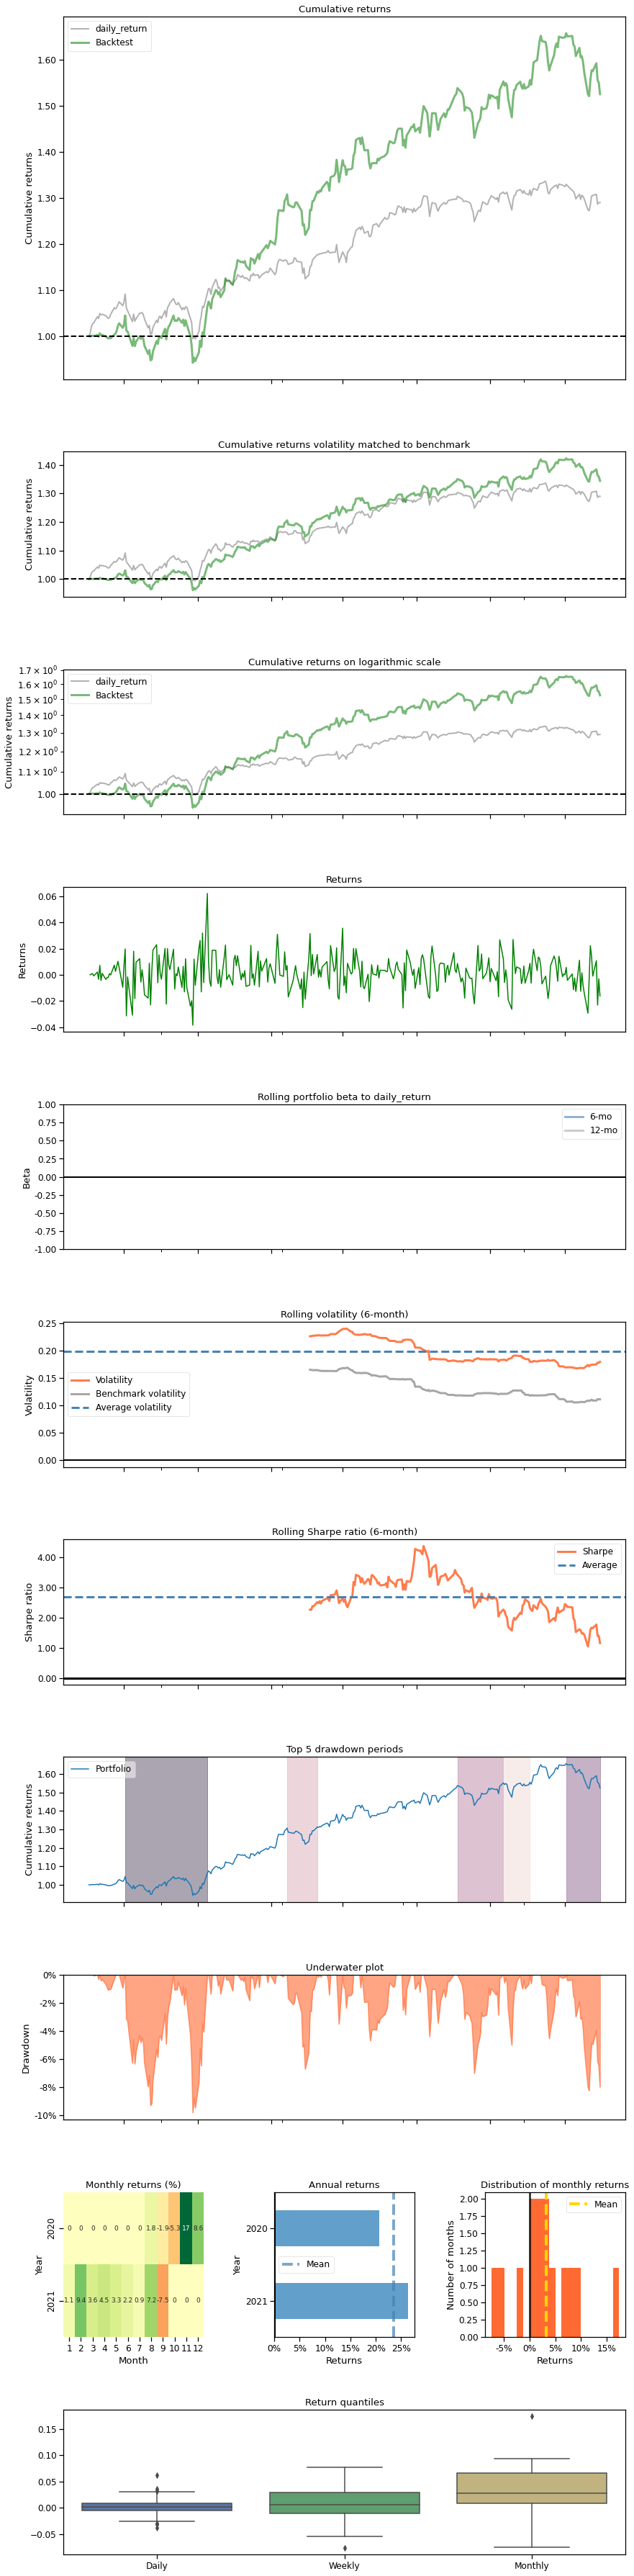

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(account_value_sb3, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_sb3.loc[0,'date'],
             baseline_end = account_value_sb3.loc[len(account_value_sb3)-1,'date'])